In [40]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = 'Desktop/Amazon Sale Report.csv'

# Error handling for file loading
try:
    sales_data = pd.read_csv(file_path,low_memory=False)
    print (sales_data.head())
except FileNotFoundError:
    print("File not found. Please check the file path.")
    raise




   index             Order ID       Date                        Status  \
0      0  405-8078784-5731545  4/30/2022                     Cancelled   
1      1  171-9198151-1101146  4/30/2022  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  4/30/2022                       Shipped   
3      3  403-9615377-8133951  4/30/2022                     Cancelled   
4      4  407-1069790-7240320  4/30/2022                       Shipped   

  Fulfilment Sales Channel  ship-service-level    Style              SKU  \
0   Merchant      Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant      Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon      Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant      Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon      Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        Category  ... currency  Amount    ship-city   ship-state  \
0            Set  ...      INR

In [41]:
# Drop irrelevant columns
sales_data_cleaned = sales_data.drop(columns=['index', 'Unnamed: 22'], errors='ignore')

In [42]:
# Handle missing values
sales_data_cleaned['Amount'] = sales_data_cleaned['Amount'].fillna(0)
categorical_columns = ['Courier Status', 'currency', 'fulfilled-by', 'promotion-ids']
for col in categorical_columns:
    sales_data_cleaned[col] = sales_data_cleaned[col].fillna('Unknown')

In [43]:
# Convert 'Date' column to datetime format with error handling
try:
    sales_data_cleaned['Date'] = pd.to_datetime(sales_data_cleaned['Date'], errors='coerce')
except Exception as e:
    print(f"Error in datetime conversion: {e}")
    raise


In [44]:
# Remove duplicates and handle negative/zero values in 'Amount'
sales_data_cleaned = sales_data_cleaned.drop_duplicates()
sales_data_cleaned = sales_data_cleaned[sales_data_cleaned['Amount'] > 0]

In [45]:
# Exploratory Data Analysis (EDA)
# Total sales by category
category_sales = sales_data_cleaned.groupby('Category')['Amount'].sum().sort_values(ascending=False)
# Total sales by state
state_sales = sales_data_cleaned.groupby('ship-state')['Amount'].sum().sort_values(ascending=False)
# Monthly sales trends
sales_data_cleaned['Month'] = sales_data_cleaned['Date'].dt.to_period('M')
monthly_sales = sales_data_cleaned.groupby('Month')['Amount'].sum()


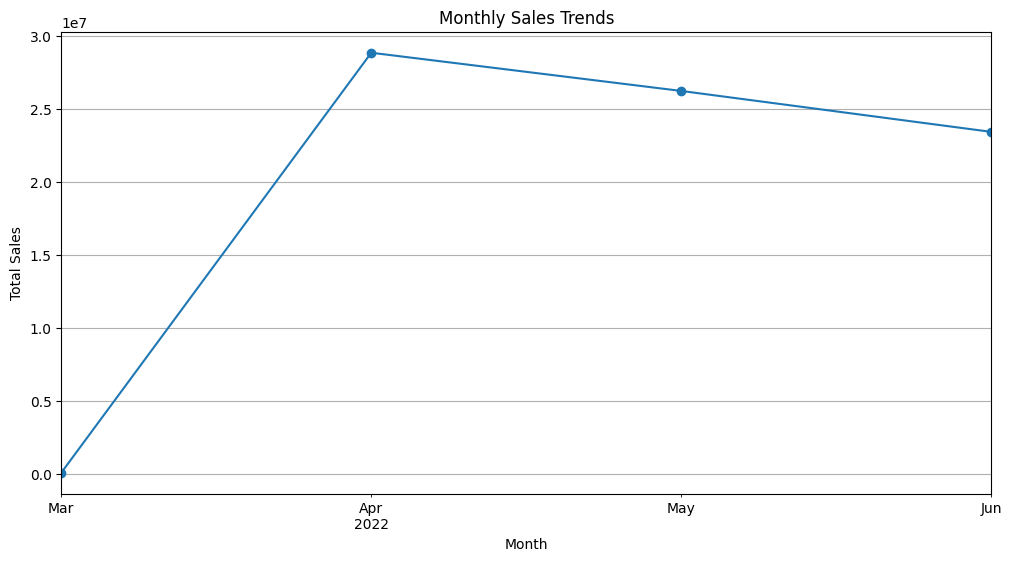

In [46]:
# Plot: Sales trends over time
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid()
plt.show()


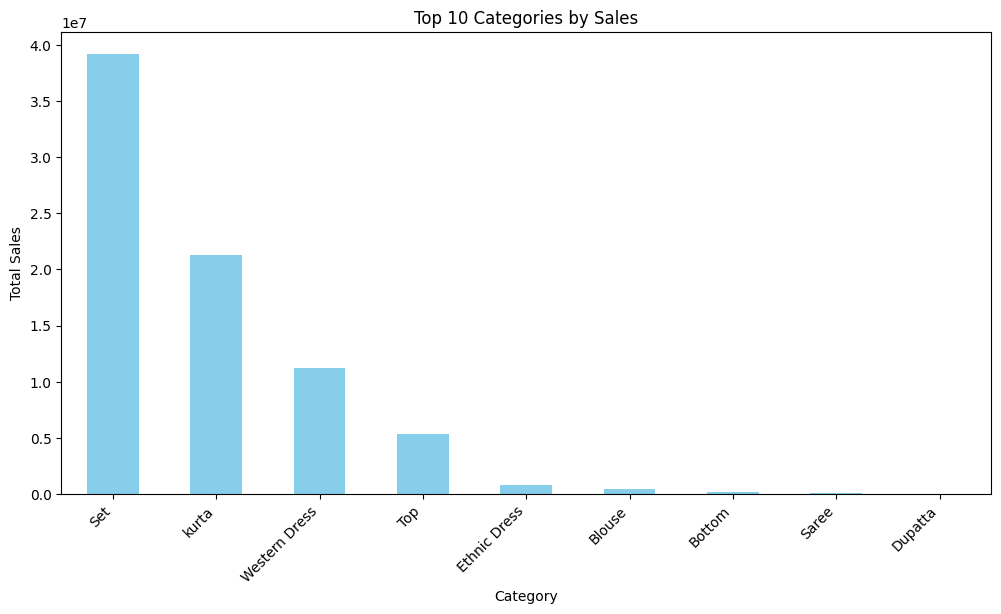

In [47]:
# Plot: Sales by category (Top 10)
plt.figure(figsize=(12, 6))
category_sales.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Categories by Sales')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.show()


In [48]:
# Key Metrics
sales_data_cleaned['Cost Allocation'] = (sales_data_cleaned['Amount'] / sales_data_cleaned['Amount'].sum()) * 100


In [49]:
# Prepare data for ARIMA
df = monthly_sales.reset_index()
df.columns = ['ds', 'y']
df['ds'] = df['ds'].dt.to_timestamp()

# Fit ARIMA model
model = ARIMA(df['y'], order=(2, 1, 0))  # You can adjust (p, d, q) as per the data
model_fit = model.fit()

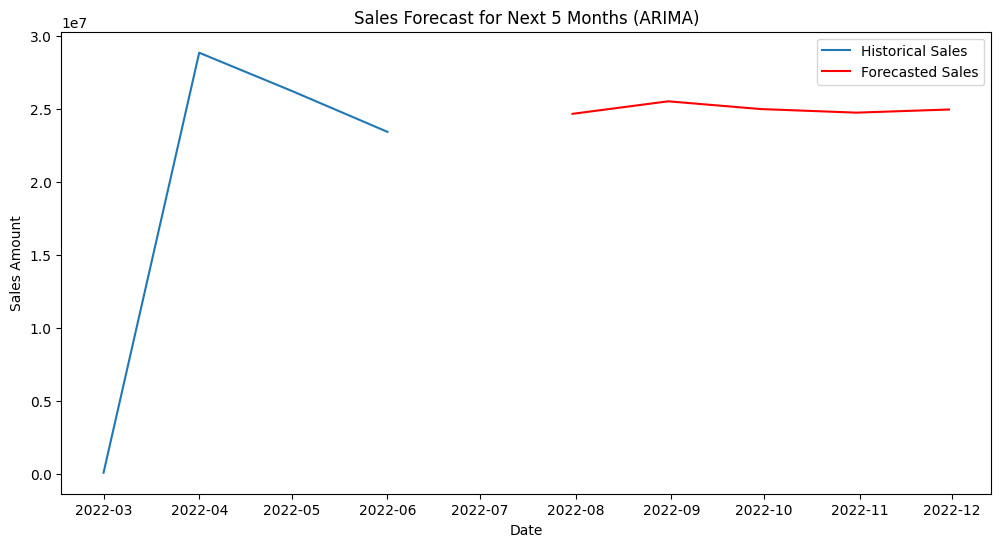

In [50]:
# Make predictions
forecast_steps = 5 # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Sales')
forecast_index = pd.date_range(start=df['ds'].iloc[-1], periods=forecast_steps + 1, freq='ME')[1:]
plt.plot(forecast_index, forecast, color='red', label='Forecasted Sales')
plt.title('Sales Forecast for Next 5 Months (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()


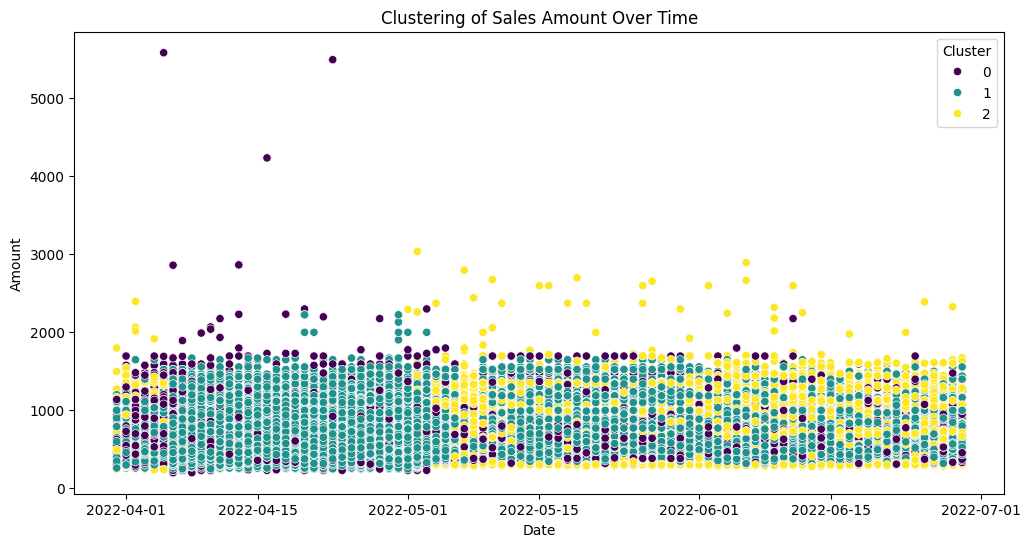

In [77]:
# Factorize the 'Category' column and keep it alongside 'Amount' for clustering
sales_data_cleaned['Category_Factorized'] = pd.factorize(sales_data_cleaned['Category'])[0]

# Apply KMeans clustering with 9 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
sales_data_cleaned['Cluster'] = kmeans.fit_predict(sales_data_cleaned[['Amount', 'Category']].apply(lambda x: pd.factorize(x)[0]))

# Plot: Clustering Results
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sales_data_cleaned, x='Date', y='Amount', hue='Cluster', palette='viridis')
plt.title('Clustering of Sales Amount Over Time')
plt.show()

In [52]:
# Summary of Insights
print("Top Categories by Sales:\n", category_sales.head(10))
print("Top States by Sales:\n", state_sales.head(10))
print("Predicted Future Sales:\n", forecast)

# Save processed data
sales_data_cleaned.to_csv('Cleaned_Amazon_Sales_Report.csv', index=False)


Top Categories by Sales:
 Category
Set              39202022.03
kurta            21299013.70
Western Dress    11216072.69
Top               5347792.30
Ethnic Dress       791217.66
Blouse             458408.18
Bottom             150667.98
Saree              123933.76
Dupatta               915.00
Name: Amount, dtype: float64
Top States by Sales:
 ship-state
MAHARASHTRA       13334595.14
KARNATAKA         10481114.37
TELANGANA          6916615.65
UTTAR PRADESH      6816109.08
TAMIL NADU         6515650.11
DELHI              4235215.97
KERALA             3830227.58
WEST BENGAL        3507880.44
ANDHRA PRADESH     3219831.72
HARYANA            2882092.99
Name: Amount, dtype: float64
Predicted Future Sales:
 4    2.465799e+07
5    2.551434e+07
6    2.498345e+07
7    2.473846e+07
8    2.495340e+07
Name: predicted_mean, dtype: float64


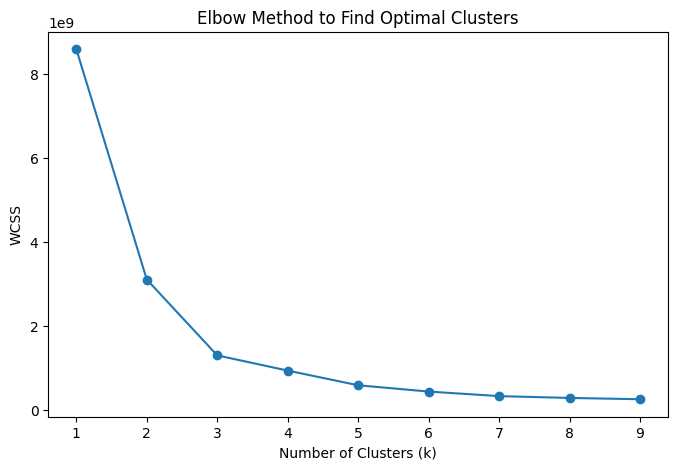

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select features for clustering
features = sales_data_cleaned[['Amount', 'Category']]
# Convert 'Category' to numeric if not already
features['Category'] = features['Category'].factorize()[0]

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method to Find Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()


Calculating Silhouette Scores...
Silhouette Score for k=2: 0.44153272295338414
Silhouette Score for k=3: 0.4471608773436574
Silhouette Score for k=4: 0.5227835760142935
Silhouette Score for k=5: 0.5221575772565111
Silhouette Score for k=6: 0.6032452101530058
Silhouette Score for k=7: 0.6008989534449143
Silhouette Score for k=8: 0.5870789769447603
Silhouette Score for k=9: 0.5889655087628226

Optimal number of clusters based on Silhouette Score: 6


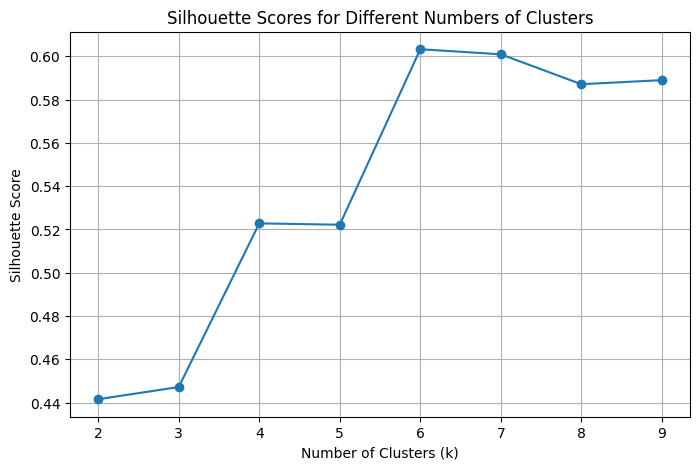


Performing final clustering with optimal k...


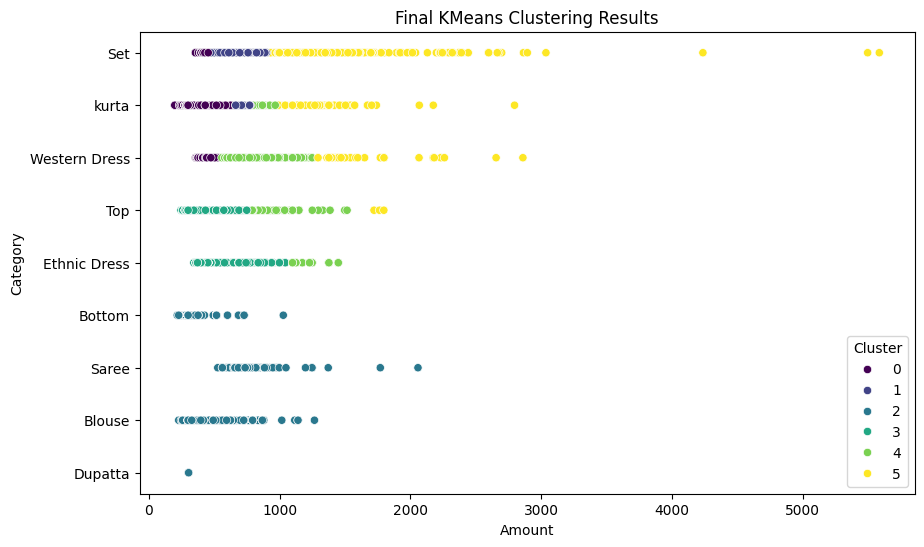


Cluster Assignments:
   Amount       Category  Cluster
0  647.62            Set        1
1  406.00          kurta        0
2  329.00          kurta        0
3  753.33  Western Dress        4
4  574.00            Top        3


In [54]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")  # To suppress warnings for cleaner output

# Sample Data Preparation (Replace with your actual dataset)
# Assuming sales_data_cleaned is already loaded
# and includes 'Amount' and 'Category' columns.

# Prepare Features
features = sales_data_cleaned[['Amount', 'Category']].copy()

# Ensure 'Amount' has no missing or invalid values
features = features[features['Amount'] > 0]

# Convert 'Category' to numeric values using factorization
features['Category'] = features['Category'].factorize()[0]

# Check for any null values
features = features.dropna()

# Scale Features (KMeans is sensitive to scaling)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Initialize list to store silhouette scores
silhouette_scores = []

# Calculate Silhouette Scores for different numbers of clusters
print("Calculating Silhouette Scores...")
for k in range(2, 10):  # Silhouette score is not defined for k=1
    try:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(features_scaled)
        score = silhouette_score(features_scaled, cluster_labels)
        silhouette_scores.append((k, score))
        print(f"Silhouette Score for k={k}: {score}")
    except Exception as e:
        print(f"An error occurred for k={k}: {e}")

# Determine the optimal number of clusters
optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_k}")

# Visualize Silhouette Scores
import matplotlib.pyplot as plt

# Extract k and scores for plotting
k_values, scores = zip(*silhouette_scores)

plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

# Final Clustering with Optimal k
print("\nPerforming final clustering with optimal k...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
sales_data_cleaned['Cluster'] = kmeans_final.fit_predict(features_scaled)

# Visualize Final Clusters
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_data_cleaned, x='Amount', y='Category', hue='Cluster', palette='viridis')
plt.title('Final KMeans Clustering Results')
plt.xlabel('Amount')
plt.ylabel('Category')
plt.legend(title='Cluster')
plt.show()

# Print cluster assignment summary
print("\nCluster Assignments:")
print(sales_data_cleaned[['Amount', 'Category', 'Cluster']].head())


In [74]:
print(forecast)

4    2.465799e+07
5    2.551434e+07
6    2.498345e+07
7    2.473846e+07
8    2.495340e+07
Name: predicted_mean, dtype: float64
